#  CVE & Vulnerabilities
L'analisi esplora le vulnerabilità CVE, evidenziando pattern ricorrenti tra le categorie CWE più critiche e i vettori d’attacco più sfruttati. Il lavoro mette in luce i tipi di vulnerabilità che dominano il panorama tecnologico, l’obiettivo è identificare i punti di concentrazione delle vulnerabilità più gravi, evidenziando correlazioni tra categorie CWE, impatto CVSS e modalità di attacco.

## Struttura del Dataset `cve`
Il dataset si basa sullo standard CVE (Common Vulnerabilities and Exposures), una nomenclatura riconosciuta a livello mondiale per la **classificazione, tracciamento e analisi delle vulnerabilità di sicurezza informatica**. Ogni riga del dataset rappresenta una vulnerabilità informatica identificata ufficialmente e contiene informazioni tecniche, temporali e contestuali per permettere analisi e monitoraggi dettagliati. Il file include le seguenti colonne principali:

- **`id`**: identificativo univoco della vulnerabilità nel formato CVE-YYYY-NNNN.
- **`year`**: anno in cui la vulnerabilità è stata pubblicata o scoperta.
- **`cvss_score`**: punteggio assegnato secondo lo standard CVSS (Common Vulnerability Scoring System), che va da 0 (nessun impatto) a 10 (massimo impatto).
- **`severity`**: classificazione qualitativa della gravità (es. *Low, Medium, High, Critical*).
- **`description`**: breve descrizione della vulnerabilità, utile per identificare il contesto e la natura dell’attacco.
- **`attack_vector`**: modalità con cui la vulnerabilità può essere sfruttata (es. *Network, Local, Physical*).
- **`vulnerable_product`** *(opzionale)*: prodotto o software affetto dalla vulnerabilità.



In [94]:
import pandas as pd                        
import plotly.graph_objects as go      
import plotly.express as px                
import re                                 
df = pd.read_csv("cve.csv")
# converte la colonna 'pub_date' (data di pubblicazione) in formato datetime 
df['pub_date'] = pd.to_datetime(df['pub_date'], errors='coerce')
# estrazione anno dalla data pubblicata --> nuova colonna 'year'
df['year'] = df['pub_date'].dt.year
# reimozione di tutte le righe che non hanno anno / punteggio CVSS validi
df = df.dropna(subset=['year', 'cvss'])


### Distribuzione CVE per Gravità 

Questo grafico mostra l’**evoluzione del numero di vulnerabilità informatiche (CVE)** nel tempo, classificate secondo la scala di gravità **CVSS** in quattro categorie:

- **Low (0–3.9)** – impatto limitato
- **Medium (4–6.9)** – impatto moderato
- **High (7–8.9)** – impatto elevato
- **Critical (9–10)** – impatto massimo 

Ogni barra rappresenta un anno, suddiviso per gravità. La linea tratteggiata bianca mostra l’**incidenza percentuale delle CVE critiche** sul totale annuale.
Questa visualizzazione consente di analizzare: l’**aumento complessivo del numero di vulnerabilità** nel tempo e Il **peso crescente delle vulnerabilità critiche** 


In [95]:
#fasce di gravità CVSS
bins = [0, 3.9, 6.9, 8.9, 10]
labels = ['Low (0–3.9)', 'Medium (4–6.9)', 'High (7–8.9)', 'Critical (9–10)']
df['cvss_bin'] = pd.cut(df['cvss'], bins=bins, labels=labels)
# raggruppamento per anno e fascia
cve_bins = (
    df.groupby(['year', 'cvss_bin'], observed=True)
      .size()
      .unstack(fill_value=0)
      .reset_index()
)
cve_bins['Totali'] = cve_bins.sum(axis=1)
cve_bins['% Critiche'] = (cve_bins["Critical (9–10)"] / cve_bins['Totali']) * 100
# grafico con barre impilate + linea % critiche
fig = go.Figure()
fig.add_trace(go.Bar(
    x=cve_bins['year'],
    y=cve_bins["Low (0–3.9)"],
    name='Low (0–3.9)',
    marker_color='green',
    hovertemplate='Anno %{x}<br>Low: %{y}'
))
fig.add_trace(go.Bar(
    x=cve_bins['year'],
    y=cve_bins["Medium (4–6.9)"],
    name='Medium (4–6.9)',
    marker_color='yellow',
    hovertemplate='Anno %{x}<br>Medium: %{y}'
))
fig.add_trace(go.Bar(
    x=cve_bins['year'],
    y=cve_bins["High (7–8.9)"],
    name='High (7–8.9)',
    marker_color='orange',
    hovertemplate='Anno %{x}<br>High: %{y}'
))
fig.add_trace(go.Bar(
    x=cve_bins['year'],
    y=cve_bins["Critical (9–10)"],
    name='Critical (9–10)',
    marker_color='crimson',
    hovertemplate='Anno %{x}<br>Critical: %{y}'
))
fig.add_trace(go.Scatter(
    x=cve_bins['year'],
    y=cve_bins['% Critiche'],
    name='% Critiche',
    yaxis='y2',
    mode='lines+markers',
    line=dict(color='white', width=2, dash='dash'),
    hovertemplate='%{y:.1f}% CVE critiche nel %{x}'
))
#stile
fig.update_layout(
    barmode='stack',
    xaxis=dict(title="Anno", tickfont=dict(color='white')),
    yaxis=dict(title="Numero di CVE", tickfont=dict(color='white')),
    yaxis2=dict(
        title="% Critiche",
        overlaying='y',
        side='right',
        showgrid=False,
        tickfont=dict(color='white')
    ),
    template='plotly_dark',
    plot_bgcolor='#050b18',
    paper_bgcolor='#050b18',
    legend=dict(
        x=0.01, y=1.1,
        orientation='h',
        font=dict(family='Segoe UI', color='white', size=20)
    ),
    font=dict(family='Segoe UI', color='white', size=28),
    margin=dict(l=80, r=80, t=100, b=80)
)
fig.show()

### Distribuzione Statica delle CVE per Livello di Gravità (CVSS)

Questo grafico a barre mostra la **frequenza assoluta delle vulnerabilità  (CVE)** classificate secondo le fasce di rischio CVSS:

- **Low (0–3.9)** – rischio basso
- **Medium (4–6.9)** – rischio moderato
- **High (7–8.9)** – rischio elevato
- **Critical (9–10)** – rischio massimo

Il grafico evidenzia Il carico complessivo di minacce in ciascuna classe, le barre rappresentano **il numero totale di CVE** per ciascuna fascia, offrendo una panoramica chiara della distribuzione della gravità delle vulnerabilità. 

In [96]:
df = df.dropna(subset=['cvss'])
bins = [0, 3.9, 6.9, 8.9, 10]
labels = ['Low (0–3.9)', 'Medium (4–6.9)', 'High (7–8.9)', 'Critical (9–10)']
df['cvss_level'] = pd.cut(df['cvss'], bins=bins, labels=labels, include_lowest=True)
dist = df['cvss_level'].value_counts().sort_index()
fig = go.Figure(data=[
    go.Bar(
        x=dist.index,
        y=dist.values,
        text=dist.values,
        textposition='outside',
        textfont=dict(size=24, color='white'),
        marker_color=['green', 'yellow', 'orange', 'red'],
        cliponaxis=False
    )
])
fig.layout = go.Layout(
    xaxis=dict(
        title="Livello di Rischio",
        title_font=dict(size=28, family='Segoe UI', color='white'),
        tickfont=dict(size=28, family='Segoe UI', color='white')
    ),
    yaxis=dict(
        title="Numero di CVE",
        title_font=dict(size=28, family='Segoe UI', color='white'),
        tickfont=dict(size=28, family='Segoe UI', color='white'),
        range=[0, dist.max() * 1.2]
    ),
    template='plotly_dark',
    plot_bgcolor='#050b18',
    paper_bgcolor='#050b18',
    font=dict(family='Segoe UI', size=28, color='white')
)
fig.show()

### **Top 10 Tipi di Vulnerabilità più Comuni (CWE)**

Questo grafico mostra le **10 tipologie di vulnerabilità (CWE – Common Weakness Enumeration)** più frequenti. Ogni barra rappresenta un tipo di weakness specifica nel codice, nel design o nell’implementazione di un sistema, ordinata per numero di vulnerabilità note.
Il grafico aiuta a Comprendere **quali tipologie di difetti ricorrono più spesso nei software**. Ogni barra orizzontale rappresenta un tipo specifico di CWE, La lunghezza della barra indica **quante volte** quel tipo di debolezza è stato associato a una CVE registrata.


In [100]:
import pandas as pd

# Assicurati che 'cvss' sia numerico
df['cvss'] = pd.to_numeric(df['cvss'], errors='coerce')
df = df.dropna(subset=['cvss', 'cwe_code', 'cwe_name'])

# Trova le 10 CWE più frequenti per codice
top_cwe_codes = df['cwe_code'].value_counts().nlargest(10).index
df_top = df[df['cwe_code'].isin(top_cwe_codes)]

# Frequenza per codice CWE
freq = df_top['cwe_code'].value_counts().sort_values(ascending=True)

# Crea un mapping codice -> nome (usando la prima occorrenza disponibile)
code_to_name = df_top.drop_duplicates('cwe_code').set_index('cwe_code')['cwe_name'].to_dict()

# Etichette asse Y del tipo "CWE-89: SQL Injection"
labels_y = [f"CWE-{code}: {code_to_name.get(code, '')}" for code in freq.index]

# Plot
fig = px.bar(
    x=freq.values,
    y=labels_y,
    orientation='h',
    labels={"x": "Numero di CVE", "y": "CWE"},
    template='plotly_dark',
    color=freq.values,
    color_continuous_scale='Blues'
)

fig.update_layout(
    plot_bgcolor='#050b18',
    paper_bgcolor='#050b18',
    font=dict(family='Segoe UI', size=18, color='white'),
    coloraxis_colorbar=dict(
        title=dict(text="Frequenza", font=dict(family='Segoe UI', size=16, color='white')),
        tickfont=dict(family='Segoe UI', size=14, color='white')
    )
)

fig.show()

### Distribuzione delle CWE nelle Vulnerabilità Critiche

Questo grafico rappresenta le **CWE** più comuni, mappate rispetto alle vulnerabilità maggiormente critiche, cioè quelle con punteggio **CVSS pari o superiore a 9**. Quindi evidenzia **quali debolezze sono più spesso alla base delle CVE più gravi**. Nel grafico sono incluse solo le **8 categorie di CWE più frequenti**.

In [98]:
# preproc
df['pub_date'] = pd.to_datetime(df['pub_date'], errors='coerce')
df['year'] = df['pub_date'].dt.year
df = df.dropna(subset=['cvss', 'year', 'summary', 'cwe_code', 'cwe_name'])
# CVE critiche
crit = df[df['cvss'] >= 9].copy()
top_cwe_codes = crit['cwe_code'].value_counts().nlargest(8).index
crit_top = crit[crit['cwe_code'].isin(top_cwe_codes)]
cwe_counts = crit_top['cwe_code'].value_counts()
cwe_cvss_avg = crit_top.groupby('cwe_code')['cvss'].mean().round(1)
def clean_cwe_name(code, name):
    if code == 78: return "Command Injection"
    if code == 264: return "Permission & Privilege Issues"
    if code == 119: return "Out-of-Bounds"
    name = re.sub(r"\s*\(.*?\)", "", name)
    name = re.sub(r"^.*?:\s*", "", name)
    return name.strip()
code_to_name = {
    code: clean_cwe_name(code, crit_top[crit_top['cwe_code'] == code]['cwe_name'].iloc[0])
    for code in top_cwe_codes
}
labels = [f"CWE-{code}" for code in cwe_counts.index]
cwe_names = [code_to_name[code] for code in cwe_counts.index]
scores = [cwe_cvss_avg[code] for code in cwe_counts.index]
colors_exact = [
    '#636efa', '#ef553b', '#00cc96', '#ab63fa',
    '#ffa15a', '#19d3f3', '#ff6692', '#b6e880'
]
# figura unica
fig = go.Figure()
# pie chart a sinistra
fig.add_trace(go.Pie(
    labels=[f"{l}: {n}" for l, n in zip(labels, cwe_names)],
    values=cwe_counts.values,
    hole=0.3,
    domain=dict(x=[0, 0.5]),
    marker=dict(colors=colors_exact),
    textinfo='percent+label',
    textfont=dict(size=16, family='Segoe UI', color='white'),
    showlegend=False
))
# tab a destra
fig.add_trace(go.Table(
    domain=dict(x=[0.52, 1]),
    columnwidth=[30, 90, 30],
    header=dict(
        values=["<b>CWE</b>", "<b>Nome CWE</b>", "<b>CVSS medio</b>"],
        fill_color="#1e1e2f",
        font=dict(color='white', size=18, family='Segoe UI'),
        align="left"
    ),
    cells=dict(
        values=[
            [f"<b>{l}</b>" for l in labels],
            [f"<b>{n}</b>" for n in cwe_names],
            [f"<b>{s}</b>" for s in scores]
        ],
        fill_color=[colors_exact, ["#050b18"]*8, ["#050b18"]*8],
        font=dict(color='white', size=20, family='Segoe UI'),
        height=38,
        align="left"
    )
))
fig.update_layout(
    height=520,
    plot_bgcolor="#050b18",
    paper_bgcolor="#050b18",
    margin=dict(t=40, r=20, b=20, l=20),
    font=dict(family="Segoe UI", size=20, color="white"),
    showlegend=False
)
fig.show()

### **Top 3 CWE – andamento temporale**

Questo grafico mostra l’evoluzione annuale delle **prime 3 vulnerabilità CWE (Common Weakness Enumeration)** in termini di numero di CVE rilevati, per ogni anno presente nel dataset.
- Ogni **linea tratteggiata con marker circolare** rappresenta una specifica CWE tra le prime 3 più frequenti di un anno.
- L’asse **X** indica l’**anno di pubblicazione** delle vulnerabilità.
- L’asse **Y** mostra il **numero di CVE** associate a quella CWE nell’anno, considerando solamente le top 3 annuali.



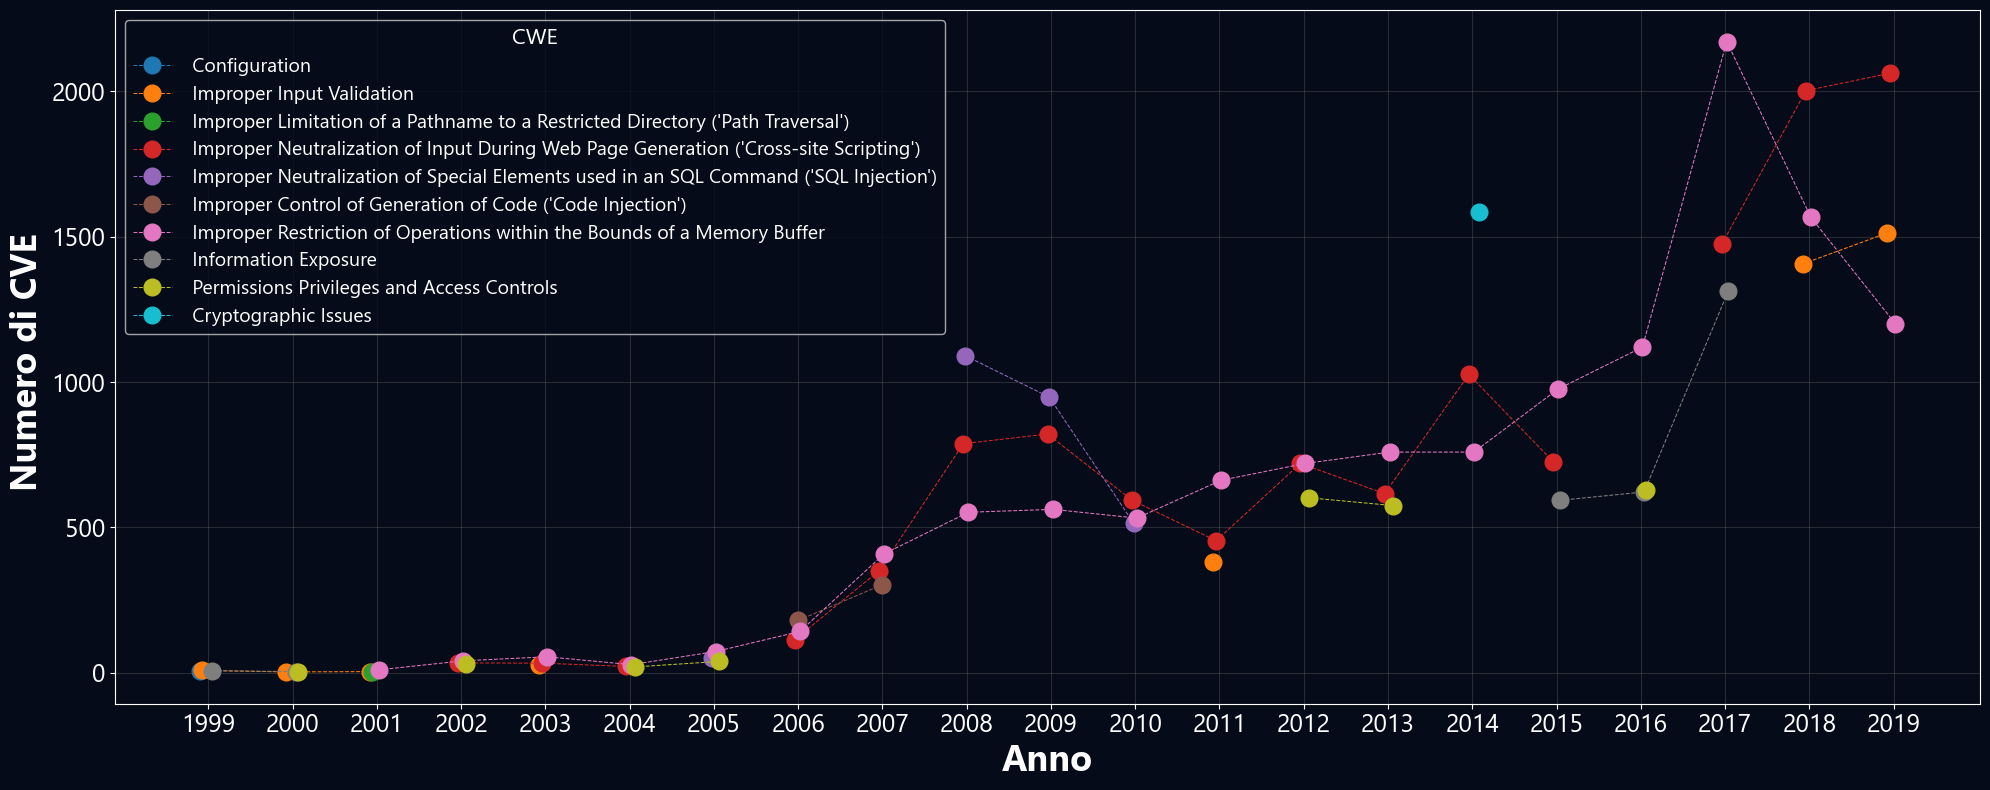

In [99]:

import matplotlib.pyplot as plt
# Estrazione top 3 CWE per anno come fatto in precedenza
top3_per_year = (
    df.groupby(['year', 'cwe_code', 'cwe_name'])
      .size()
      .reset_index(name='count')
      .sort_values(['year', 'count'], ascending=[True, False])
      .groupby('year')
      .head(3)
)

# 🔁 Pivot in base ai codici CWE, mantenendo i nomi completi
pivot_df = top3_per_year.pivot(index='year', columns='cwe_code', values='count')

# 📚 Mappa codice → nome completo della CWE
code_to_name = top3_per_year.set_index('cwe_code')['cwe_name'].to_dict()

# 🎨 Stile grafico uguale
plt.rcParams.update({
    'axes.facecolor': '#050b18',
    'figure.facecolor': '#050b18',
    'savefig.facecolor': '#050b18',
    'font.family': 'Segoe UI',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.edgecolor': 'white',
    'legend.facecolor': '#050b18',
})

plt.figure(figsize=(20, 8))

n = len(pivot_df.columns)
offset = 0.2
for i, cwe_code in enumerate(pivot_df.columns):
    x = pivot_df.index + (i - n/2) * (offset / n)
    plt.plot(
        x,
        pivot_df[cwe_code],
        linestyle='--',
        linewidth=0.75,
        marker='o',
        markersize=12,
        label=code_to_name[cwe_code]
    )

plt.xticks(
    pivot_df.index.astype(int),
    rotation=0,
    fontsize=18  # aumentiamo la dimensione dei tick X
)
plt.yticks(fontsize=18)  # aumentiamo la dimensione dei tick Y

plt.xlabel("Anno", fontsize=26, fontweight='bold')
plt.ylabel("Numero di CVE ", fontsize=26, fontweight='bold')

plt.grid(alpha=0.2)
plt.legend(title="CWE", fontsize=14, title_fontsize=16)
plt.tight_layout()
plt.show()